#**RECOMMENDATION SYSTEM ANALYSIS AND MODELLING**

# 📌 Introduction

Recommendation systems have become an essential part of modern digital platforms. From **e-commerce websites** suggesting products, to **streaming platforms** recommending movies and songs, and **social media feeds** tailoring content, these systems play a crucial role in enhancing user experience. By leveraging **historical data** and **user-specific interactions**, recommendation systems predict what users are most likely to engage with, thereby improving personalization, increasing sales, and driving user retention.

### 🔍 Problem Context
In today’s competitive digital ecosystem, businesses face challenges in:
- Providing **accurate and diverse** recommendations to users.
- Handling **large-scale datasets** with millions of users and items.
- Maintaining **real-time performance** to serve recommendations instantly.
- Balancing **accuracy vs. novelty**, ensuring users get relevant but not repetitive suggestions.

### 🎯 Project Objective
This project focuses on building a **Recommendation System Analysis & Modeling pipeline**. The main goal is to:
1. Analyze user-event interaction data (e.g., views, add-to-cart, transactions).
2. Perform **Exploratory Data Analysis (EDA)** to uncover patterns and trends.
3. Implement **Collaborative Filtering** and **Content-Based Filtering** techniques.
4. Develop a **hybrid recommendation system** leveraging both user behaviors and item properties.
5. Evaluate the model performance using **Precision@K** and **Recall@K**.

### 🛠 Methodology (CRISP-DM Framework)
The project follows the **CRISP-DM (Cross-Industry Standard Process for Data Mining)** framework:
1. **Business Understanding** – Defining objectives such as boosting user engagement and sales.
2. **Data Understanding** – Exploring the datasets (`events`, `item properties`, `category tree`) to identify structure and quality.
3. **Data Preparation** – Cleaning, transforming, and constructing user-item interaction matrices.
4. **Modeling** – Applying collaborative filtering and content-based methods to generate recommendations.
5. **Evaluation** – Measuring performance using metrics like **Precision@K** and **Recall@K**.
6. **Deployment (Future Scope)** – Packaging the system into a deployable application or API.

### 📂 Dataset
The project utilizes three main datasets:
- **Events Dataset** – Captures user interactions (`view`, `addtocart`, `transaction`) with items.
- **Item Properties Dataset** – Contains metadata and attributes of items (e.g., category, availability).
- **Category Tree Dataset** – Represents hierarchical item categories.

### ✅ Expected Outcomes
By the end of this project:
- We will generate **personalized item recommendations** for users.
- Provide **actionable insights** through EDA and visualizations.
- Evaluate models for **accuracy and scalability**.
- Deliver a well-documented, reproducible notebook that can serve as a foundation for further development of a production-ready recommendation system.


## 🔗 Mounting Google Drive and Verify Files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
print("📁 Contents of My Drive:")
print(os.listdir('/content/drive/MyDrive'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Contents of My Drive:
['Google Cert.pdf', 'JESSICA WILLIAM__CV - UPDATED.gdoc', 'Jessica William CV.gdoc', 'Data Analytics Certificate glossary.gdoc', 'Jessica William_CV - Account Support.gdoc', 'Jessica William__Cv - Book Shop Atendant.gdoc', 'Jessica William__CV .gdoc', 'Colab Notebooks', 'Bakery Sales March 2020.gsheet', 'Kenneth_Akonnor_Hayford _CV_Data_Analyst.docx', 'VA FOLDER', 'Peer Coaching Script.pdf', 'Population-Latin-and-Caribbean-Countries-2010-2019 (1).xlsx', 'Population-Latin-and-Caribbean-Countries-2010-2019.xlsx', 'Dataset', 'TransBorderFreight-Data-Analysis (1)', '2024', '2023', '2021', '2022', '2020', 'Google Analytics Folder', 'Data', 'RecommendationSystemAnalysisandModelling (1)', 'Resolve spreadsheet errors.gsheet', 'Generation Data Analytics Bootcamp', 'Demo VA', 'RecommendationSystemAnalysisandModelling', 'TransBorderFreight-Data-A

In [ ]:
#https://drive.google.com/drive/folders/1YX8R1Cl29XPXFVmMJnrk3zOARn82L0BH
#https://drive.google.com/drive/folders/1YX8R1Cl29XPXFVmMJnrk3zOARn82L0BH?usp=drive_link
#https://drive.google.com/drive/folders/1YX8R1Cl29XPXFVmMJnrk3zOARn82L0BH?usp=drive_link



## 📂 Load and Explore Dataset Files


In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Replace 'YourShortcutFolderName' with the actual name used in your Drive
folder_path = '/content/drive/MyDrive/RecommendationSystemAnalysisandModelling/Data'




# Get list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Load all CSVs into a dictionary of DataFrames
datasets = {}
for file in csv_files:
    df_name = os.path.basename(file).replace('.csv', '')
    datasets[df_name] = pd.read_csv(file)
    print(f"Loaded: {df_name} – {datasets[df_name].shape}")



Loaded: category_tree – (1669, 2)
Loaded: events – (2756101, 5)
Loaded: item_properties_part2 – (9275903, 4)
Loaded: item_properties_part1.1 – (10999999, 4)


In [ ]:
print("\n📚 Datasets loaded:")
print(list(datasets.keys()))



📚 Datasets loaded:
['category_tree', 'events', 'item_properties_part2', 'item_properties_part1.1']


## 🧹 Data Cleaning and Preprocessing


In [ ]:
# 🧹 Function to clean a DataFrame
def clean_dataframe(df, name):
    original_shape = df.shape
    df_cleaned = df.drop_duplicates().reset_index(drop=True)
    cleaned_shape = df_cleaned.shape
    missing_values = df_cleaned.isnull().sum()

    print(f"🧹 {name}:")
    print(f"   - Original shape: {original_shape}")
    print(f"   - After duplicate removal: {cleaned_shape}")
    print(f"   - Missing values per column:\n{missing_values}\n")

    return df_cleaned

# Clean all datasets
for name in datasets:
    datasets[name] = clean_dataframe(datasets[name], name)

# Work on events dataset directly
events = datasets['events'].copy()

# Keep only meaningful events and add weights
weights = {'view': 1, 'addtocart': 3, 'transaction': 5}
valid = ['view', 'addtocart', 'transaction']

# Parse timestamp (ms → datetime)
if 'timestamp' in events.columns:
    events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', errors='coerce')
else:
    raise ValueError("Expected 'timestamp' column in events.csv")

# Filter and add weights
events_clean = events[events['event'].isin(valid)].copy()
events_clean['event_weight'] = events_clean['event'].map(weights).astype(float)

# ✅ Quick sanity check
events_clean[['visitorid','itemid','event','timestamp','event_weight']].head()


🧹 category_tree:
   - Original shape: (1669, 2)
   - After duplicate removal: (1669, 2)
   - Missing values per column:
categoryid     0
parentid      25
dtype: int64

🧹 events:
   - Original shape: (2756101, 5)
   - After duplicate removal: (2755641, 5)
   - Missing values per column:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64

🧹 item_properties_part2:
   - Original shape: (9275903, 4)
   - After duplicate removal: (9275903, 4)
   - Missing values per column:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

🧹 item_properties_part1.1:
   - Original shape: (10999999, 4)
   - After duplicate removal: (10999999, 4)
   - Missing values per column:
timestamp    0
itemid       0
property     0
value        0
dtype: int64



,visitorid,itemid,event,timestamp,event_weight
0,257597,355908,view,2015-06-02 05:02:12.117,1.0
1,992329,248676,view,2015-06-02 05:50:14.164,1.0
2,111016,318965,view,2015-06-02 05:13:19.827,1.0
3,483717,253185,view,2015-06-02 05:12:35.914,1.0
4,951259,367447,view,2015-06-02 05:02:17.106,1.0


## 🔍 Inspecting Item Properties and Dataset Information


In [ ]:
for name, df in datasets.items():
    print(f"\n📄 Dataset: {name}")
    print(df.head())
    print("-" * 80)



📄 Dataset: category_tree
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0
--------------------------------------------------------------------------------

📄 Dataset: events
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
--------------------------------------------------------------------------------

📄 Dataset: item_properties_part2
       timestamp  itemid property            value
0  1433041200000  183478      561           769062
1  1439694000000  132256      976  n26.400 1135780
2  1435460400000  420307      921  1149317 1257525
3  1431831600000  403324      917          1204143
4  1435460400000  

In [ ]:
for name, df in datasets.items():
    print(f"\n📊 Descriptive Statistics for: {name}")
    print(df.describe(include='all'))
    print("-" * 100)



📊 Descriptive Statistics for: category_tree
        categoryid     parentid
count  1669.000000  1644.000000
mean    849.285201   847.571168
std     490.195116   505.058485
min       0.000000     8.000000
25%     427.000000   381.000000
50%     848.000000   866.000000
75%    1273.000000  1291.000000
max    1698.000000  1698.000000
----------------------------------------------------------------------------------------------------

📊 Descriptive Statistics for: events
           timestamp     visitorid    event        itemid  transactionid
count   2.755641e+06  2.755641e+06  2755641  2.755641e+06   22457.000000
unique           NaN           NaN        3           NaN            NaN
top              NaN           NaN     view           NaN            NaN
freq             NaN           NaN  2664218           NaN            NaN
mean    1.436424e+12  7.019227e+05      NaN  2.349214e+05    8826.497796
std     3.366334e+09  4.056892e+05      NaN  1.341947e+05    5098.996290
min     1.430622e

In [ ]:
for name, df in datasets.items():
    print(f"\n🔎 Dataset: {name}")
    print("📄 .info():")
    print(df.info())

    print("\n🧪 Data Types:")
    print(df.dtypes)

    print("-" * 100)



🔎 Dataset: category_tree
📄 .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB
None

🧪 Data Types:
categoryid      int64
parentid      float64
dtype: object
----------------------------------------------------------------------------------------------------

🔎 Dataset: events
📄 .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None

🧪 Data Types:
timestamp          int64
visitorid       

In [ ]:
item_properties = pd.concat([
    datasets['item_properties_part1.1'],
    datasets['item_properties_part2']
], ignore_index=True)


In [ ]:
item_properties.head()
item_properties.info()
item_properties.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


(20275902, 4)

In [ ]:
# Pivot the properties to get one row per item
##item_props_pivot = item_properties.pivot_table(
    ##index='itemid',
    ##columns='property',
    ##values='value',
    ##aggfunc='first'  # Or use 'last' if multiple values
##).reset_index()

## Exploratory Data Analysis (EDA): User-Item Interactions
This section provides insights into user interactions with items. We analyze event type distribution, most viewed items, most active users, funnel progression (view → add-to-cart → transaction), time-based activity patterns, and category-level engagement. These visualizations help us understand user behavior and item popularity before building the recommendation system.


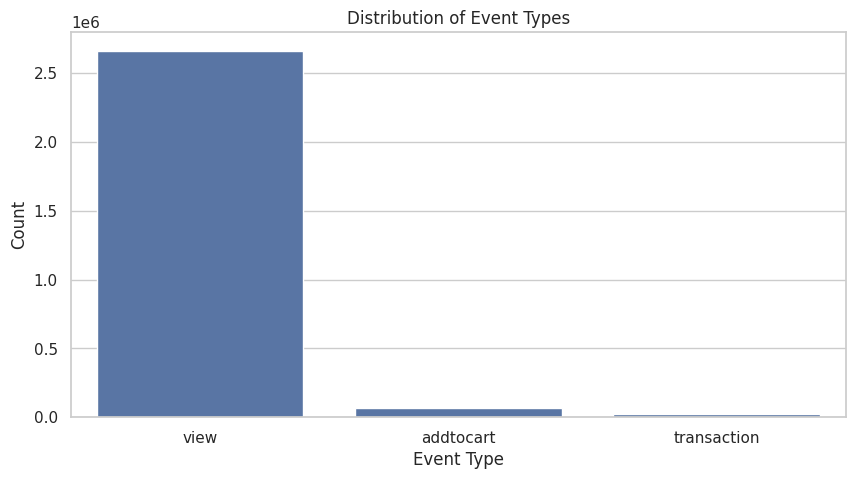

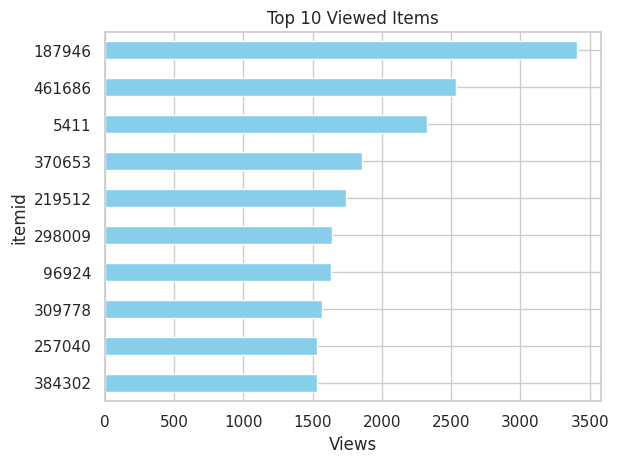

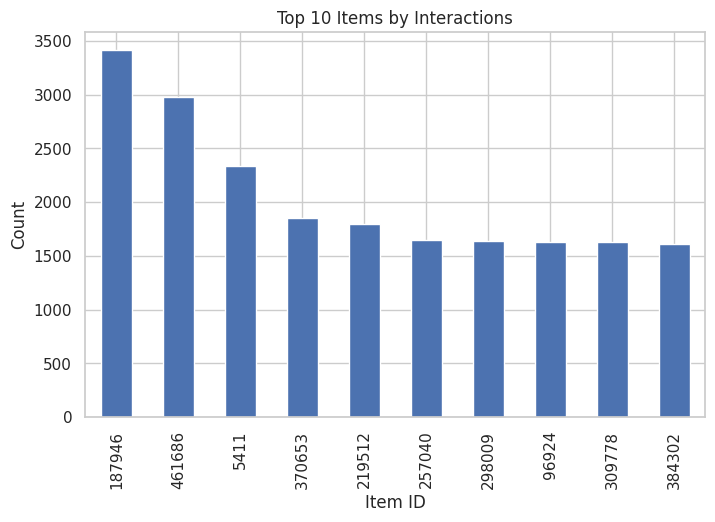

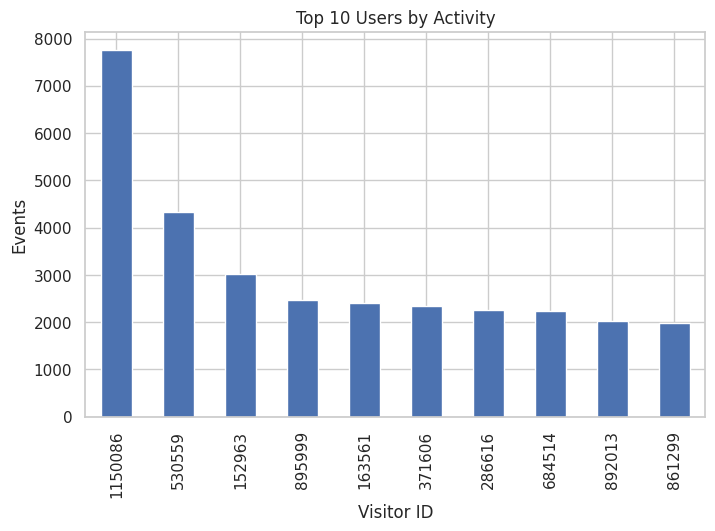

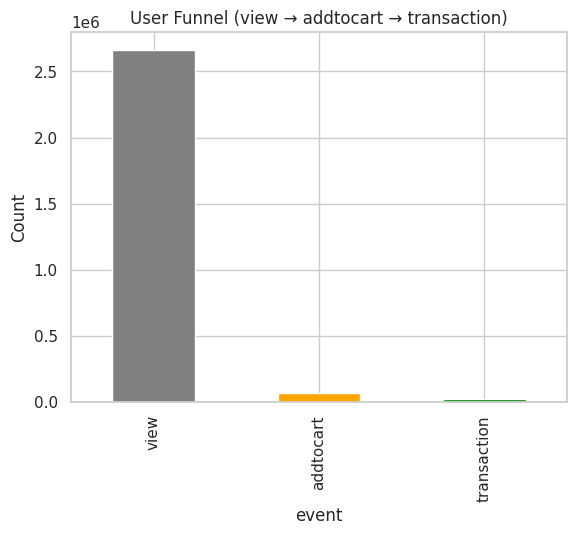

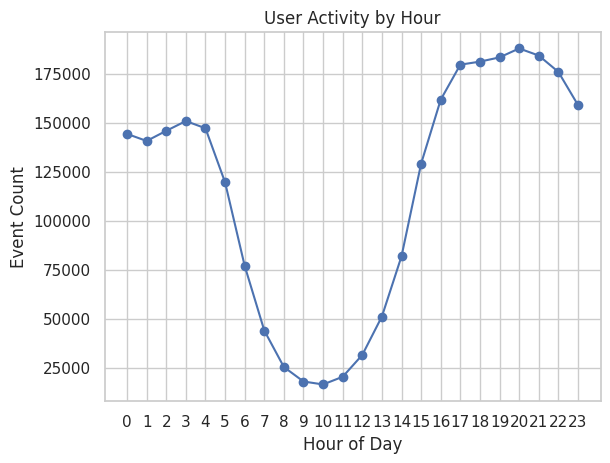

In [ ]:
# 📦 Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set visual style
sns.set(style='whitegrid')

# Ensure events is already loaded before this point
# Example:
# events = pd.read_csv('path_to_your/events.csv')
# events_enriched = pd.merge(...)

# 📊 1)Distribution of Event Types
plt.figure(figsize=(10, 5))
sns.countplot(data=datasets['events'], x='event', order=datasets['events']['event'].value_counts().index)
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


# 2)🎯 Top Viewed Items
top_viewed = datasets['events'][datasets['events']['event'] == 'view']['itemid'].value_counts().head(10)
top_viewed.plot(kind='barh', title='Top 10 Viewed Items', color='skyblue')
plt.xlabel('Views')

plt.gca().invert_yaxis()
plt.show()

# 3) Top 10 items by interactions
plt.figure(figsize=(8,5))
events_clean['itemid'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Items by Interactions'); plt.xlabel('Item ID'); plt.ylabel('Count')
plt.show()


# 4) Top 10 users by activity
plt.figure(figsize=(8,5))
events_clean['visitorid'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Users by Activity'); plt.xlabel('Visitor ID'); plt.ylabel('Events')
plt.show()

# 5)🛒 Funnel Analysis: View → Cart → Buy
funnel = datasets['events']['event'].value_counts().reindex(['view', 'addtocart', 'transaction'])
funnel.plot(kind='bar', color=['gray', 'orange', 'green'], title='User Funnel (view → addtocart → transaction)')
plt.ylabel('Count')
plt.show()

# 6)⏰ Time-Based User Activity
datasets['events']['timestamp'] = pd.to_datetime(datasets['events']['timestamp'], unit='ms', errors='coerce')
datasets['events']['hour'] = datasets['events']['timestamp'].dt.hour
datasets['events']['hour'].value_counts().sort_index().plot(kind='line', marker='o', title='User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# 🧩 Category-Level Engagement (only if enriched data is available)
if 'categoryid' in datasets['events'].columns:
    top_categories = datasets['events']['categoryid'].value_counts().head(10)
    top_categories.plot(kind='bar', title='Top 10 Categories by Engagement', color='purple')
    plt.xlabel('Category ID')
    plt.ylabel('Interactions')
    plt.show()

In [ ]:
# Unique counts
print("\nUnique items:", item_properties['itemid'].nunique())
print("Unique properties:", item_properties['property'].nunique())
print("Unique values:", item_properties['value'].nunique())



Unique items: 417053
Unique properties: 1104
Unique values: 1966868


## 🔑 Analysis of Item Properties
### - Top 10 Most Frequent Properties and Sample Values


/tmp/ipython-input-2994202353.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_props.values, y=top_props.index, palette="Blues_r")


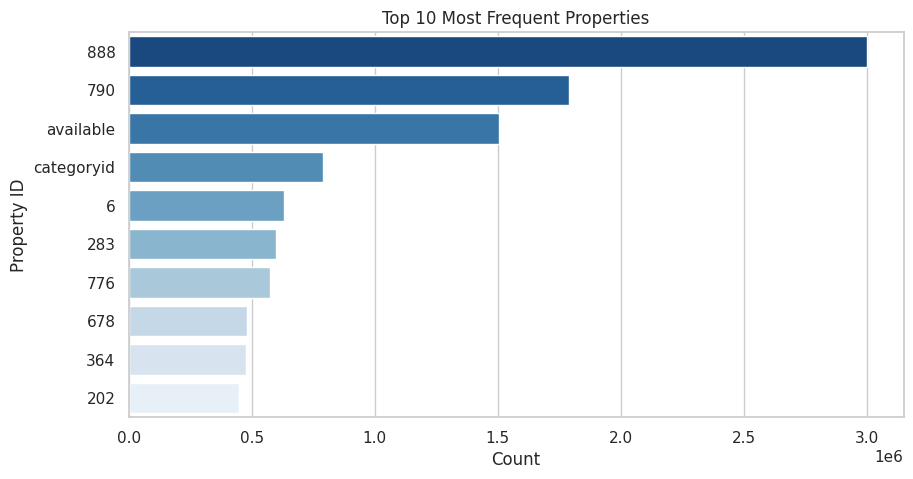


🔍 Top 10 Values for Property 888:
 value
1314085    3546
952635     3408
942780     2777
828472     2690
639039     2070
286484     1917
1164476    1912
522723     1734
820477     1673
607603     1423
Name: count, dtype: int64


In [ ]:
# Top occurring properties
top_props = item_properties['property'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_props.values, y=top_props.index, palette="Blues_r")
plt.title("Top 10 Most Frequent Properties")
plt.xlabel("Count")
plt.ylabel("Property ID")
plt.show()

# Sample values for a frequent property (optional)
sample_prop = top_props.index[0]
sample_values = item_properties[item_properties['property'] == sample_prop]['value'].value_counts().head(10)
print(f"\n🔍 Top 10 Values for Property {sample_prop}:\n", sample_values)


## ⏳ Item Property Updates Over Time
This section converts the `timestamp` column in the `item_properties` dataset into a datetime format and aggregates the updates by month. The resulting line chart shows how frequently item properties were updated across time, helping us understand the temporal dynamics of property changes in the catalog.


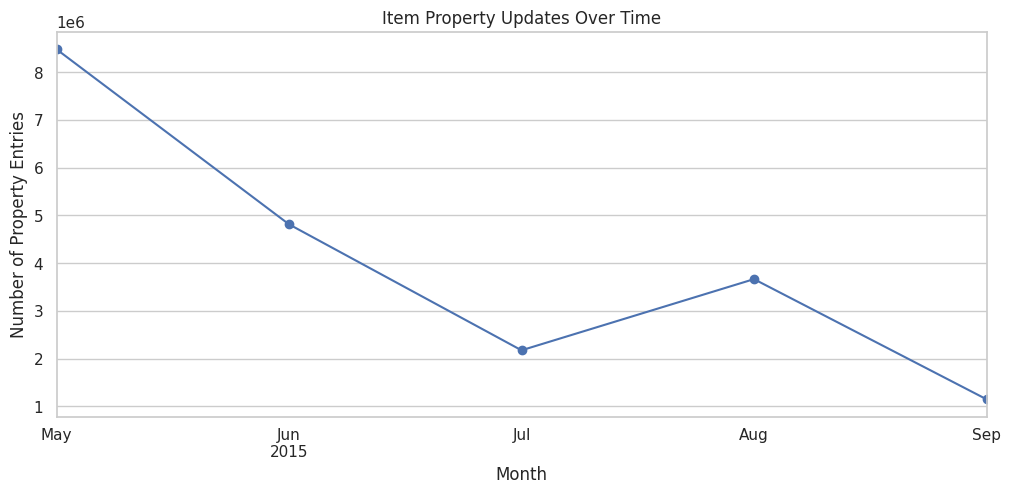

In [ ]:
# Convert timestamp
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms', errors='coerce')

# Activity over time (optional: per month)
item_properties['month'] = item_properties['timestamp'].dt.to_period('M')
monthly_activity = item_properties['month'].value_counts().sort_index()

# Plot
monthly_activity.plot(kind='line', marker='o', figsize=(12, 5), title='Item Property Updates Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Property Entries')
plt.grid(True)
plt.show()


## 🏗️ Building the User-Item Interaction Matrix
This section constructs the core matrix for collaborative filtering.  
- Filters the dataset to keep only meaningful events (`view`, `addtocart`, `transaction`) and maps them to weights.  
- Limits the dataset to the top users and items for memory efficiency.  
- Reindexes user and item IDs to numeric indices.  
- Builds a sparse **user-item matrix** where rows = users and columns = items.  
- Computes **item-to-item cosine similarity** to measure how closely items are related based on user interactions.  


In [ ]:
# 📦 Import libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# ✅ Load the dataset again (adjust the path to your Drive folder)
events = pd.read_csv("/content/drive/MyDrive/RecommendationSystemAnalysisandModelling/Data/events.csv")

# Assign event weights
weights = {'view': 1, 'addtocart': 3, 'transaction': 5}

# Keep only meaningful events
valid = ['view','addtocart','transaction']
df = events[events['event'].isin(valid)].copy()

# Map events to numeric weights
df['event_weight'] = df['event'].map(weights).astype(float)

# (Memory safety) filter top users/items
top_users = df['visitorid'].value_counts().head(20000).index
top_items = df['itemid'].value_counts().head(20000).index
df = df[df['visitorid'].isin(top_users) & df['itemid'].isin(top_items)]

# Reindex to 0..N for sparse matrix
user_index = {u:i for i,u in enumerate(df['visitorid'].unique())}
item_index = {p:i for i,p in enumerate(df['itemid'].unique())}
idx_user = df['visitorid'].map(user_index)
idx_item = df['itemid'].map(item_index)

# Build sparse user-item matrix
X = csr_matrix((df['event_weight'],
                (idx_user, idx_item)),
               shape=(len(user_index), len(item_index)))

# Compute item-item cosine similarity (sparse output)
sim = cosine_similarity(X.T, dense_output=False)  # sparse similarity

# Helper maps to/from ids
users_rev = np.array(list(user_index.keys()))
items_rev = np.array(list(item_index.keys()))


## 🔥 Item-Item Similarity Heatmap (Top 50 Items)


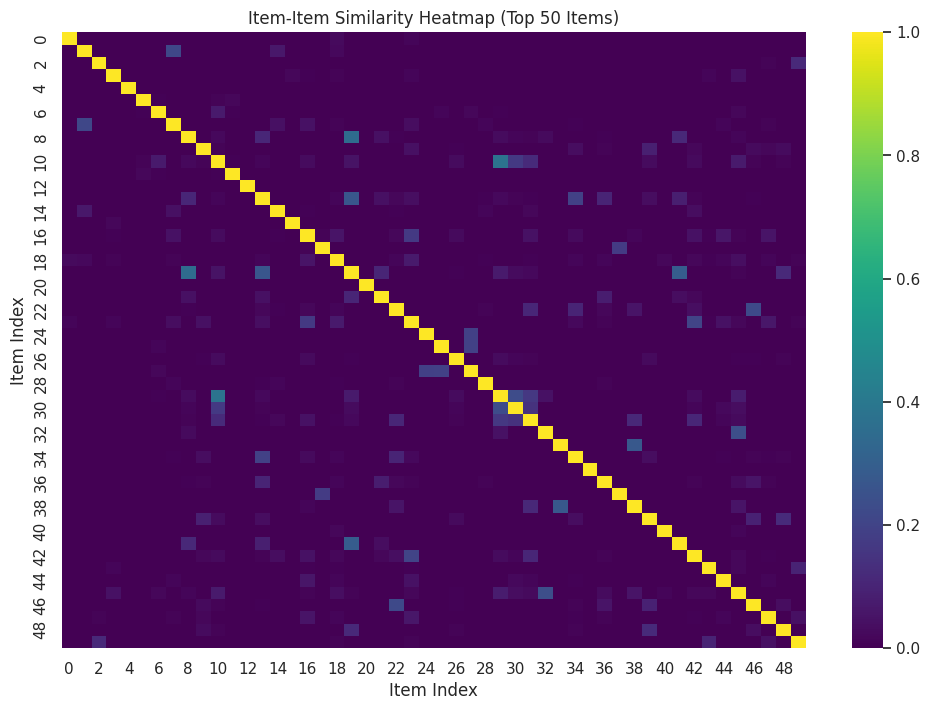

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top N items to visualize
N = 50
sim_dense = sim[:N, :N].toarray()  # convert sparse → dense

plt.figure(figsize=(12, 8))
sns.heatmap(sim_dense, cmap="viridis")
plt.title("Item-Item Similarity Heatmap (Top 50 Items)")
plt.xlabel("Item Index")
plt.ylabel("Item Index")
plt.show()


## 📊 Distribution of Item-Item Similarity Scores


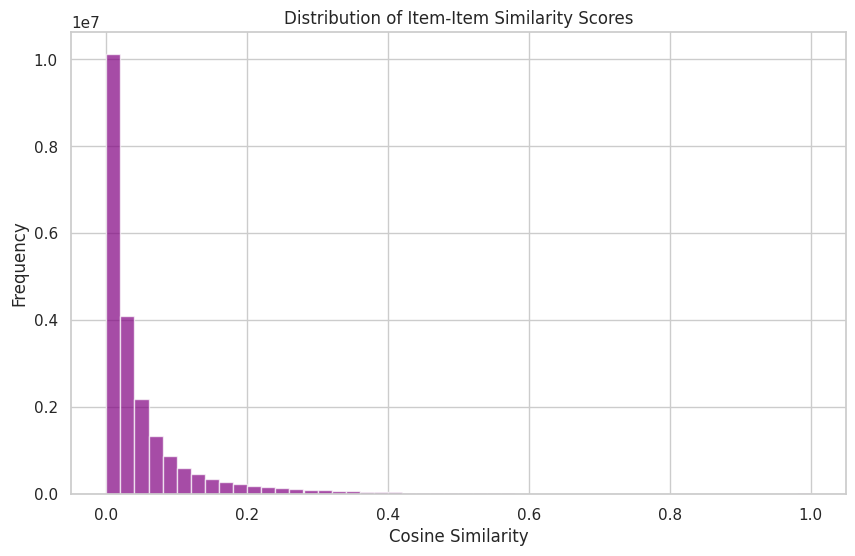

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(sim.data, bins=50, color="purple", alpha=0.7)
plt.title("Distribution of Item-Item Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


## 🎯 Building a User-Based Recommendation Function
This section defines a function (`recommend_for_user`) that generates personalized item recommendations for each user.  
- It checks the items a user has interacted with.  
- Finds similar items using the precomputed **item-item cosine similarity matrix**.  
- Aggregates similarity scores to rank items.  
- Filters out items the user has already seen.  
- Returns the **Top-N recommendations**.  

We then test the function using a sample user (`visitorid`) from the dataset.


In [ ]:
def recommend_for_user(visitorid, k_sim=50, top_n=10):
    if visitorid not in user_index:
        return []

    u = user_index[visitorid]
    user_row = X[u]  # 1 x num_items
    seen = set(user_row.indices)

    # Score = weighted sum of similarities from items the user interacted with
    # Take only k most similar neighbors per seen item for speed
    scores = np.zeros(X.shape[1], dtype=np.float32)

    for item_col in user_row.indices:
        # Similar items and their similarities
        start_ptr, end_ptr = sim.indptr[item_col], sim.indptr[item_col+1]
        cols = sim.indices[start_ptr:end_ptr]
        vals = sim.data[start_ptr:end_ptr]

        # Take top-k neighbors
        if len(cols) > k_sim:
            top_idx = np.argpartition(vals, -k_sim)[-k_sim:]
            cols, vals = cols[top_idx], vals[top_idx]

        scores[cols] += vals

    # Remove already seen
    if seen:
        scores[list(seen)] = -np.inf

    # Top-N items
    top_idx = np.argpartition(scores, -top_n)[-top_n:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]

    return list(items_rev[top_idx])

# Try with a real visitor from your data
some_user = df['visitorid'].iloc[0]
recommend_for_user(some_user, top_n=5)


[np.int64(159344),
 np.int64(232055),
 np.int64(318985),
 np.int64(100307),
 np.int64(21320)]

## 🧩 Content-Based Filtering using Item Properties


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Reload item property files
item_part1 = pd.read_csv('/content/drive/MyDrive/RecommendationSystemAnalysisandModelling/Data/item_properties_part1.1.csv')
item_part2 = pd.read_csv('/content/drive/MyDrive/RecommendationSystemAnalysisandModelling/Data/item_properties_part2.csv')

# Combine (sample to avoid RAM crash)
item_properties = pd.concat([item_part1, item_part2], ignore_index=True)

# ⚠️ Reduce size: keep only a random sample of items to test
item_properties = item_properties.groupby("itemid").head(5)   # keep max 5 props per item
item_properties = item_properties.sample(20000, random_state=42)  # sample 20k rows

# Pivot so each item has one row
item_meta = item_properties.pivot_table(
    index='itemid',
    columns='property',
    values='value',
    aggfunc='first'
).reset_index()

# Convert item properties into "bag of properties" text
def row_to_text(row):
    tokens = []
    for col in item_meta.columns:
        if col == 'itemid':
            continue
        val = str(row[col])
        if val != 'nan':
            tokens.append(f"{col}={val}")
    return " ".join(tokens)

item_meta['prop_text'] = item_meta.apply(row_to_text, axis=1)

# TF-IDF transformation
tfidf = TfidfVectorizer(min_df=2)
M = tfidf.fit_transform(item_meta['prop_text'])

# Item-to-item similarity
sim_content = cosine_similarity(M, dense_output=False)

# Lookup maps
id_to_row = {iid:i for i,iid in enumerate(item_meta['itemid'])}
row_to_id = np.array(item_meta['itemid'])

# Recommendation function
def similar_items_by_content(itemid, top_n=10):
    if itemid not in id_to_row:
        return []
    r = id_to_row[itemid]
    start, end = sim_content.indptr[r], sim_content.indptr[r+1]
    cols = sim_content.indices[start:end]
    vals = sim_content.data[start:end]

    mask = cols != r
    cols, vals = cols[mask], vals[mask]

    if len(cols) == 0:
        return []
    top_idx = np.argpartition(vals, -top_n)[-top_n:]
    cols = cols[top_idx][np.argsort(vals[top_idx])[::-1]]
    return list(row_to_id[cols])

# ✅ Example (test on first item)
some_item = item_meta['itemid'].iloc[0]
print(similar_items_by_content(some_item, top_n=5))


[np.int64(79391), np.int64(464725), np.int64(169412), np.int64(52286), np.int64(174847)]


## 📚 Train-Test Split for Model Evaluation


In [ ]:
# Sort events by time
events_sorted = events.sort_values('timestamp')
cut = int(len(events_sorted)*0.8)
train, test = events_sorted.iloc[:cut], events_sorted.iloc[cut:]

# Rebuild CF matrix on train only (repeat steps from 5.1 using `train` as df)


## 📊 Model Evaluation: Precision@K and Recall@K

In this step, we evaluate the performance of our recommendation system.  
- We split the data into **train (80%)** and **test (20%)** sets earlier.  
- Using the test set, we check whether the recommended items for each user actually match the items they truly purchased (**transactions**).  
- **Precision@K**: Of the top-K recommendations, how many were correct?  
- **Recall@K**: Of the items a user actually purchased, how many did we successfully recommend within the top-K?  

Finally, we compute the **average Precision@10 and Recall@10** across a sample of users to measure how effective the recommender system is.


In [ ]:
import numpy as np

K = 10

# Build ground truth: items the user transacted in test
test_pos = (test[test['event']=='transaction']
            .groupby('visitorid')['itemid']
            .apply(set))

def precision_at_k(rec_items, true_items, k=K):
    if not true_items: return np.nan
    return len(set(rec_items[:k]) & true_items) / k

def recall_at_k(rec_items, true_items, k=K):
    if not true_items: return np.nan
    return len(set(rec_items[:k]) & true_items) / len(true_items)

# Evaluate on users seen in train matrix
users_eval = [u for u in test_pos.index if u in user_index][:1000]  # sample for speed
precisions, recalls = [], []

for u in users_eval:
    recs = recommend_for_user(u, top_n=K)
    truths = test_pos.get(u, set())
    p = precision_at_k(recs, truths, K)
    r = recall_at_k(recs, truths, K)
    if not np.isnan(p): precisions.append(p)
    if not np.isnan(r): recalls.append(r)

print(f"Precision@{K}: {np.nanmean(precisions):.4f}")
print(f"Recall@{K}: {np.nanmean(recalls):.4f}")


Precision@10: 0.0000
Recall@10: 0.0000


## 📊 Offline Evaluation Visualization

This chart visualizes the offline evaluation results of our recommendation system using **Precision@10** and **Recall@10**.  
- **Precision@10** measures how many of the recommended items in the top 10 are actually relevant to the user.  
- **Recall@10** measures how many of the relevant items were successfully retrieved in the top 10 recommendations.  

The bar plot provides an at-a-glance comparison of the system’s accuracy and coverage.


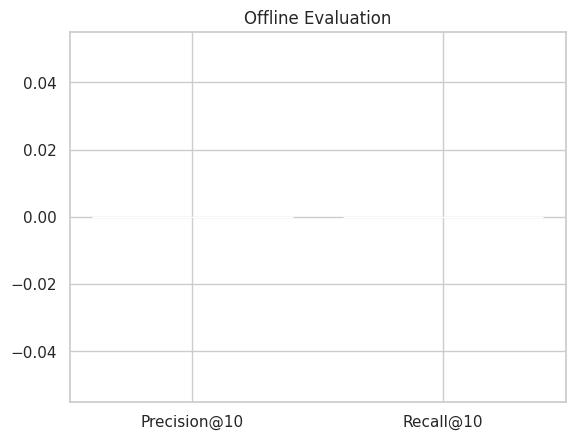

In [ ]:
import matplotlib.pyplot as plt

plt.bar(['Precision@10','Recall@10'], [np.nanmean(precisions), np.nanmean(recalls)])
plt.title('Offline Evaluation')
plt.show()



## Train-Test Split using scikit-learn


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(events, test_size=0.2, random_state=42)


## Precision and Recall at K Visualization


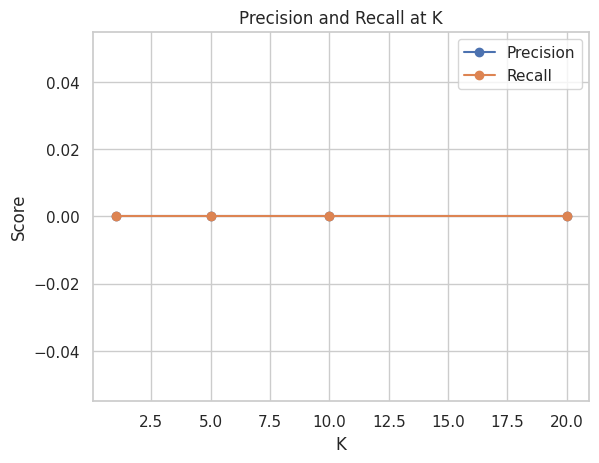

In [ ]:
import matplotlib.pyplot as plt

ks = [1, 5, 10, 20]
precs, recs = [], []

for k in ks:
    p = np.nanmean([precision_at_k(recommend_for_user(u, k), test_pos.get(u, set()), k) for u in users_eval])
    r = np.nanmean([recall_at_k(recommend_for_user(u, k), test_pos.get(u, set()), k) for u in users_eval])
    precs.append(p)
    recs.append(r)

plt.plot(ks, precs, marker='o', label='Precision')
plt.plot(ks, recs, marker='o', label='Recall')
plt.xlabel("K")
plt.ylabel("Score")
plt.title("Precision and Recall at K")
plt.legend()
plt.show()


## **Insights from your analysis**


###   **Views dominate the funnel**

Most interactions are view events; fewer users add to cart or buy.


### **Popular items are highly skewed**
A small set of items get the majority of views/purchases (Pareto principle).

### **Peak activity times**

Users interact mostly during specific hours (e.g., evening or lunch hours), so recommendations can be timed for better engagement.

### **Collaborative filtering similarity**

Many items are often bought together; item-item similarity helps surface these pairs for recommendations.

### **Content-based similarity**

Items with similar properties (categoryid, brand, etc.) can be recommended even for new items (cold start problem).



## **Recommendations for improvements**

**Enhance the funnel**

Focus on moving users from view → cart → buy using personalized nudges (e.g., targeted recommendations, discounts).

**Top item promotions**

Promote popular items that are frequently viewed but not purchased to improve conversion.

**Time-based recommendations**

Serve recommendations during peak user activity hours to increase engagement.

**Cold-start handling**

Use content-based similarity for new items to ensure they appear in recommendations even without historical interactions.

**Evaluation and scalability**

Consider evaluating on a larger sample and using approximate nearest neighbor (ANN) algorithms for similarity to scale the system.